## Создание ML-моделей 

### Библиотеки и пользовательские функции

In [1]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

from catboost import CatBoostRegressor
from xgboost import XGBRegressor

from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint


In [2]:
def create_df():
    '''
    Функция для создания датафрейма для сохранения метрик
    
    '''
    df = pd.DataFrame(columns=['Модель',
                               'Прогнозируемая переменная',
                               'Лучшие параметры',
                               'Среднеквадратическая ошибка (MSE)',
                               'Коэффициент детерминации (R^2)']
                      ).set_index(['Модель'])
    return df

In [3]:
def tune_model(model, param_grid):
    '''
    Функция подбора гиперпараметров
    Выводит и возвращает словарь с параметрами
    
    '''
    
    # Поиск по сетке
    grid_search = GridSearchCV(
                               model,
                               param_grid=param_grid, 
                               scoring='neg_mean_squared_error',
                               cv=cv,
                               verbose=True, n_jobs=-1
                               )
    grid_search.fit(X_train, y_module_train)
    
    # Лучшие параметры
    print()
    print(
          pd.DataFrame(grid_search.best_params_,
          index=[f'Параметры лучшей модели {type(model).__name__}']).T
          )
    
    return grid_search.best_params_


In [4]:
def save_model(model, best_param, models_dict):
    '''
    Функция сохраняет модель и выбранные параметры  в словарь models_dict...
    
    '''
    
    model_name = type(model).__name__
    models_dict[model_name] = {
          'model': model,
          'params': best_param
                              }

Функции для оценивания моделей кросс-валидацией

In [5]:
# для модуля упругости при растяжении

def score_module(model, best_param):
    '''
    Функция, рассчитывающая метрики MSE и R2
    Печатает метрики
    Вносит метрики в итоговую таблицу
    Сохраняет модель в словарь
    
    '''
    
    # метрики для оценок
    scoring = ["neg_mean_squared_error", "r2"]
    
    # расчет на кросс-валидации
    scores = cross_validate(model, X_train, y_module_train, cv=cv, scoring=scoring, n_jobs=-1)
    # scores  возвращает словарь
    
    # вывод оценок
    print(f'Оценка {type(model).__name__} на обучающей выборке')
    print("Mean MSE:", -scores["test_neg_mean_squared_error"].mean().round(4), "±", scores["test_neg_mean_squared_error"].std().round(4))
    print("Mean R^2:", scores["test_r2"].mean().round(4), "±", scores["test_r2"].std().round(4))
    
    # заполнение датафрейма оценками
    df_module.loc[type(model).__name__] = ['Модуль упругости при растяжении',
                                            best_param,
    f"{-scores['test_neg_mean_squared_error'].mean():.3f} ± {scores['test_neg_mean_squared_error'].std():.3f}",
    f"{scores['test_r2'].mean():.3f} ± {scores['test_r2'].std():.3f}"]
    
    # пользовательская функция сохранения модели в словарь
    save_model(model, best_param, models_dict_module)


In [6]:
# для прочности при растяжении

def score_strength(model, best_param):
    '''
    Функция, рассчитывающая метрики MSE и R2
    Печатает метрики
    Вносит метрики в итоговую таблицу
    Сохраняет модель в словарь
    
    '''
    
    # метрики для оценок
    scoring = ["neg_mean_squared_error", "r2"]
    
    # расчет на кросс-валидации
    scores = cross_validate(model, X_train, y_strength_train, cv=cv, scoring=scoring, n_jobs=-1)
    # scores  возвращает словарь
    
    # вывод оценок
    print(f'Оценка {type(model).__name__} на обучающей выборке')
    print("Mean MSE:", -scores["test_neg_mean_squared_error"].mean().round(4), "±", scores["test_neg_mean_squared_error"].std().round(4))
    print("Mean R^2:", scores["test_r2"].mean().round(4), "±", scores["test_r2"].std().round(4))
    
    # заполнение датафрейма оценками
    df_strength.loc[type(model).__name__] = ['Прочность при растяжении',
                                              best_param,
    f"{-scores['test_neg_mean_squared_error'].mean():.3f} ± {scores['test_neg_mean_squared_error'].std():.3f}",
    f"{scores['test_r2'].mean():.3f} ± {scores['test_r2'].std():.3f}"]
    
    # пользовательская функция сохранения модели в словарь
    save_model(model, best_param, models_dict_strength)


Функция для оценивания моделей на тестовой выборке

In [7]:
def test(models_dict, y_train, y_test):
    '''
    Функция оценки модели на тестовой выборке
    
    '''
    
    # пустой датафрейм
    df = create_df()
    
    # для каждой модели в словаре моделей
    for name, model_dict in models_dict.items():
        # извлекаем модель
        model = model_dict['model']
        # извлекаем параметры
        best_param = model_dict['params']
        
        # обучение модели на train-выборке и прогноз на test-выборке
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # оценка качества прогнозов на тестовой выборке
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
    
        # заполнение датафрейма оценками
        df.loc[type(model).__name__] = [y_train.name[:-5],
                                        best_param,
                                        f"{mse:.3f}",
                                        f"{r2:.3f} "]
    
    return df

In [8]:

# Стратегия перекрестной проверки
cv = RepeatedKFold(n_splits=10, n_repeats=2, random_state=0)


### Подготовка данных

In [9]:
data = pd.read_csv('../data/processed_save_real_data.csv')
data.columns

Index(['Количество отвердителя, м.%', 'Содержание эпоксидных групп, %',
       'Температура вспышки, С', 'Потребление смолы, г/м2',
       'Угол нашивки, град', 'Шаг нашивки', 'Плотность нашивки',
       'Плотность, кг/м3', 'Поверхностная плотность, г/м2',
       'Модуль упругости, ГПа', 'Соотношение матрица-наполнитель',
       'Модуль упругости при растяжении, ГПа',
       'Прочность при растяжении, МПа'],
      dtype='object')

In [10]:
module = data['Модуль упругости при растяжении, ГПа']   # целевая переменная
strength = data['Прочность при растяжении, МПа']        # целевая переменная

X = data.drop(columns=
              ['Модуль упругости при растяжении, ГПа',  # признаки
               'Прочность при растяжении, МПа'])
len(X.columns)

11

In [11]:
# Разбиваем на train и test

X_train, X_test,                    \
y_module_train, y_module_test,      \
y_strength_train, y_strength_test = \
train_test_split(
                 X, module, strength, test_size=0.3, random_state=0
                )

print(X_train.shape, y_module_train.shape, y_strength_train.shape)
print(X_test.shape, y_module_test.shape, y_strength_test.shape)

(716, 11) (716,) (716,)
(307, 11) (307,) (307,)


<font color=blue size=4>**Прогноз модуля упругости при растяжении**</font>  
переменная `module`

Метрики оценивания:
- MSE - mean squared error - среднеквадратическая ошибка  
- R<sup>2</sup> - коэффициент детерминации

In [12]:

# Датафрейм для записи MSE и R2
df_module = create_df()

# Пустой словарь для перечня моделей и их параметров
models_dict_module = {}


#### Градиентный бустинг  XGBoost

In [13]:
param_xgb = {
              'booster': ['gbtree', 'dart'],            # dart - c прорежеванием
              'n_estimators': [10, 50, 100, 500],       # число деревьев
              'max_depth': [3, 5, 7, 10],               # максимальная глубина дерева
              'learning_rate': [0.01, 0.02, 0.1, 0.3],
              'subsample': [0.5, 0.7, 1.0],             # доля обучающих образцов
              'colsample_bytree': [0.5, 0.7, 1.0],      # доля обучающих признаков
              'n_jobs': [-1]
             }

Используем среднеквадратическую ошибку MSE в качестве функции потерь, в xgboost - squarederror задана по умолчанию. Оптимизация модели заключается в нахождении такого набора параметров модели, при котором среднее значение квадратов разностей между фактическими и прогнозируемыми значениями будет минимальным.

In [14]:

xgb = XGBRegressor(random_state=0)   # tree_method="gpu_hist"

# Функция подбора гиперпараметров
best_param_xgb = tune_model(xgb, param_xgb)


Fitting 20 folds for each of 1152 candidates, totalling 23040 fits

                 Параметры лучшей модели XGBRegressor
booster                                        gbtree
colsample_bytree                                  1.0
learning_rate                                    0.02
max_depth                                           3
n_estimators                                       10
n_jobs                                             -1
subsample                                         0.5


In [15]:

# Создание модели с лучшими параметрами
best_xgb = XGBRegressor(random_state=0, **best_param_xgb)

# Функция, рассчитывающая метрики MSE и R2 
score_module(best_xgb, best_param_xgb)


Оценка XGBRegressor на обучающей выборке
Mean MSE: 0.0367 ± 0.0051
Mean R^2: -0.0134 ± 0.0265


#### Градиентный бустинг CatBoost

In [16]:
param_catboost = {
                 'learning_rate': [0.01, 0.1],
                 'depth': [4, 6, 7, 10],         # глубина дерева решений
                 'l2_leaf_reg': [0.1, 1, 10],    # коэффициент регуляризации L2
                 'iterations': [10, 50, 100]     # количество итераций обучения
                  }

In [17]:

# по умолчанию все ядра процессора
# task_type="GPU"

catboost = CatBoostRegressor(random_state=0, logging_level='Silent')

# Функция подбора гиперпараметров
best_param_catboost = tune_model(catboost, param_catboost)


Fitting 20 folds for each of 72 candidates, totalling 1440 fits

               Параметры лучшей модели CatBoostRegressor
depth                                                7.0
iterations                                          10.0
l2_leaf_reg                                          1.0
learning_rate                                        0.1


In [18]:

# Создание модели с лучшими параметрами
best_catboost = CatBoostRegressor(random_state=0, **best_param_catboost)

# Функция, рассчитывающая метрики MSE и R2 
score_module(best_catboost, best_param_catboost)


Оценка CatBoostRegressor на обучающей выборке
Mean MSE: 0.0367 ± 0.0049
Mean R^2: -0.0138 ± 0.0448


#### Случайный лес

In [19]:
param_forest = {
                'n_estimators': [50, 100, 200],
                'max_depth': [2, 3, 5, 7],
                'min_samples_split': [2, 4, 8],
                'min_samples_leaf': [1, 2, 4],
               }

In [20]:

forest = RandomForestRegressor(random_state=0)

# Функция подбора гиперпараметров
best_param_forest = tune_model(forest, param_forest)


Fitting 20 folds for each of 108 candidates, totalling 2160 fits

                   Параметры лучшей модели RandomForestRegressor
max_depth                                                      2
min_samples_leaf                                               4
min_samples_split                                              2
n_estimators                                                  50


In [21]:

# Создание модели с лучшими параметрами
best_forest = RandomForestRegressor(random_state=0, **best_param_forest)

# Функция, рассчитывающая метрики MSE и R2 
score_module(best_forest, best_param_forest)


Оценка RandomForestRegressor на обучающей выборке
Mean MSE: 0.0371 ± 0.0049
Mean R^2: -0.0248 ± 0.0463


#### Полиномиальная регрессия  
Полиномиальная интерполяция с Ridge регрессией  
https://scikit-learn.org/stable/auto_examples/linear_model/plot_polynomial_interpolation.html

In [22]:
param_poly = {
              'polynomialfeatures__degree': range(1, 5),
              'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]
             }

In [23]:

poly = make_pipeline(PolynomialFeatures(), Ridge())

# Функция подбора гиперпараметров
best_param_poly = tune_model(poly, param_poly)


Fitting 20 folds for each of 24 candidates, totalling 480 fits

                            Параметры лучшей модели Pipeline
polynomialfeatures__degree                                 1
ridge__alpha                                             100


In [24]:

# Создание модели с лучшими параметрами
best_poly = make_pipeline(
            PolynomialFeatures(degree=best_param_poly['polynomialfeatures__degree']),
            Ridge(alpha=best_param_poly['ridge__alpha']))

# Функция, рассчитывающая метрики MSE и R2
score_module(best_poly, best_param_poly)


Оценка Pipeline на обучающей выборке
Mean MSE: 0.037 ± 0.005
Mean R^2: -0.0209 ± 0.0316


In [25]:
# Проверим словарь с моделями
models_dict_module

{'XGBRegressor': {'model': XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=1.0, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.02, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=3, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=10, n_jobs=-1, num_parallel_tree=None, predictor=None,
               random_state=0, ...),
  'params': {'booster': 'gbtree',
   'colsample_bytree': 1.0,
   'learning_rate': 0.02,
   'max_depth': 3,
   'n_estimators': 10,
   'n_jobs': -1,
   'subsample': 0.5}},
 'CatBoostRegressor': {'model': <catboost.core.

<font color=blue size=4>**Прогноз прочности при растяжении**</font>  
переменная `strength`

In [26]:

# Датафрейм для записи MSE и R2
df_strength = create_df()

# Пустой словарь для перечня моделей и их параметров
models_dict_strength = {}


Воспользуемся теми же словарями с гиперпараметрами, что и для моделей для модуля упругости при растяжении  
#### Градиентный бустинг  XGBoost

In [27]:

xgb_strength = XGBRegressor(random_state=0)   # tree_method="gpu_hist"

# Функция подбора гиперпараметров
best_param_xgb_strength = tune_model(xgb_strength, param_xgb)


Fitting 20 folds for each of 1152 candidates, totalling 23040 fits

                 Параметры лучшей модели XGBRegressor
booster                                        gbtree
colsample_bytree                                  1.0
learning_rate                                    0.02
max_depth                                           3
n_estimators                                       10
n_jobs                                             -1
subsample                                         0.5


In [28]:

# Создание модели с лучшими параметрами
best_xgb_strength = XGBRegressor(random_state=0, **best_param_xgb_strength)

# Функция, рассчитывающая метрики MSE и R2 
score_strength(best_xgb_strength, best_param_xgb_strength)


Оценка XGBRegressor на обучающей выборке
Mean MSE: 0.0366 ± 0.0039
Mean R^2: -0.0128 ± 0.0191


#### Градиентный бустинг CatBoost

In [29]:

catboost_strength = CatBoostRegressor(random_state=0, logging_level='Silent')

# Функция подбора гиперпараметров
best_param_catboost_strength = tune_model(catboost_strength, param_catboost)


Fitting 20 folds for each of 72 candidates, totalling 1440 fits

               Параметры лучшей модели CatBoostRegressor
depth                                                7.0
iterations                                          10.0
l2_leaf_reg                                          1.0
learning_rate                                        0.1


In [30]:

# Создание модели с лучшими параметрами
best_catboost_strength = CatBoostRegressor(random_state=0, **best_param_catboost_strength)

# Функция, рассчитывающая метрики MSE и R2 
score_strength(best_catboost_strength, best_param_catboost_strength)


Оценка CatBoostRegressor на обучающей выборке
Mean MSE: 0.0366 ± 0.0036
Mean R^2: -0.0133 ± 0.0436


#### Случайный лес

In [31]:

forest_strength = RandomForestRegressor(random_state=0)

# Функция подбора гиперпараметров
best_param_forest_strength = tune_model(forest_strength, param_forest)


Fitting 20 folds for each of 108 candidates, totalling 2160 fits

                   Параметры лучшей модели RandomForestRegressor
max_depth                                                      2
min_samples_leaf                                               4
min_samples_split                                              2
n_estimators                                                  50


In [32]:

# Создание модели с лучшими параметрами
best_forest_strength = RandomForestRegressor(random_state=0, **best_param_forest_strength)

# Функция, рассчитывающая метрики MSE и R2 
score_strength(best_forest_strength, best_param_forest_strength)


Оценка RandomForestRegressor на обучающей выборке
Mean MSE: 0.0368 ± 0.0038
Mean R^2: -0.0195 ± 0.0317


#### Полиномиальная регрессия  

In [33]:

poly_strength = make_pipeline(PolynomialFeatures(), Ridge())

# Функция подбора гиперпараметров
best_param_poly_strength = tune_model(poly_strength, param_poly)


Fitting 20 folds for each of 24 candidates, totalling 480 fits

                            Параметры лучшей модели Pipeline
polynomialfeatures__degree                                 1
ridge__alpha                                             100


In [34]:

# Создание модели с лучшими параметрами
best_poly_strength = make_pipeline(
                     PolynomialFeatures(
                         degree=best_param_poly_strength['polynomialfeatures__degree']),
                     Ridge(
                         alpha=best_param_poly_strength['ridge__alpha']))

# Функция, рассчитывающая метрики MSE и R2 
score_strength(best_poly_strength, best_param_poly_strength)


Оценка Pipeline на обучающей выборке
Mean MSE: 0.0365 ± 0.0036
Mean R^2: -0.01 ± 0.0241


In [35]:
# Проверим словарь с моделями
models_dict_strength

{'XGBRegressor': {'model': XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=1.0, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.02, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=3, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=10, n_jobs=-1, num_parallel_tree=None, predictor=None,
               random_state=0, ...),
  'params': {'booster': 'gbtree',
   'colsample_bytree': 1.0,
   'learning_rate': 0.02,
   'max_depth': 3,
   'n_estimators': 10,
   'n_jobs': -1,
   'subsample': 0.5}},
 'CatBoostRegressor': {'model': <catboost.core.

Сравнив точность моделей для двух прогнозируемых переменных (модуля упругости при растяжении и прочности при растяжении) на обучающей выборке, можно сделать предварительный вывод, что лучшей моделью является полиномиальная интерполяция для прочности при растяжении. Рассчитанный коэффициент детерминации для полиномиальной интерполяции имеет максимальную величину -0.01.  
При этом для всех моделей характерен отрицательный коэфиициент детерминации, а их среднеквадратическая ошибка близка. Отрицательный коэффициент детерминации говорит об отсутствии взаимосвязи в данных. Вследствие чего, ни одна модель не обладает высокой прогнозирующей способностью.

**<p style="text-align: center;">Сравнительные таблицы ошибок и коэффицентов детерминации</p>**  
**<p style="text-align: center;">различных моделей на обучающей выборке</p>**

In [36]:
df_module

,Прогнозируемая переменная,Лучшие параметры,Среднеквадратическая ошибка (MSE),Коэффициент детерминации (R^2)
Модель,,,,
XGBRegressor,Модуль упругости при растяжении,"{'booster': 'gbtree', 'colsample_bytree': 1.0,...",0.037 ± 0.005,-0.013 ± 0.027
CatBoostRegressor,Модуль упругости при растяжении,"{'depth': 7, 'iterations': 10, 'l2_leaf_reg': ...",0.037 ± 0.005,-0.014 ± 0.045
RandomForestRegressor,Модуль упругости при растяжении,"{'max_depth': 2, 'min_samples_leaf': 4, 'min_s...",0.037 ± 0.005,-0.025 ± 0.046
Pipeline,Модуль упругости при растяжении,"{'polynomialfeatures__degree': 1, 'ridge__alph...",0.037 ± 0.005,-0.021 ± 0.032


In [37]:
df_strength

,Прогнозируемая переменная,Лучшие параметры,Среднеквадратическая ошибка (MSE),Коэффициент детерминации (R^2)
Модель,,,,
XGBRegressor,Прочность при растяжении,"{'booster': 'gbtree', 'colsample_bytree': 1.0,...",0.037 ± 0.004,-0.013 ± 0.019
CatBoostRegressor,Прочность при растяжении,"{'depth': 7, 'iterations': 10, 'l2_leaf_reg': ...",0.037 ± 0.004,-0.013 ± 0.044
RandomForestRegressor,Прочность при растяжении,"{'max_depth': 2, 'min_samples_leaf': 4, 'min_s...",0.037 ± 0.004,-0.020 ± 0.032
Pipeline,Прочность при растяжении,"{'polynomialfeatures__degree': 1, 'ridge__alph...",0.036 ± 0.004,-0.010 ± 0.024


<font size=2>*Примечание*. Pipeline - комбинация полиномиальной интерполяции и Ridge-регрессии</font>

## Тестирование моделей

Модели будут извлекаться из двух словарей:  
-`models_dict_module` - для модуля упругости при растяжении  
-`models_dict_strength` - для прочности при растяжении

In [38]:
# Структура вложенных ключей словаря с моделями

for key,value in models_dict_module.items():
    print(key, ':')

    for key_in in value.keys():
        print('    ', key_in)


XGBRegressor :
     model
     params
CatBoostRegressor :
     model
     params
RandomForestRegressor :
     model
     params
Pipeline :
     model
     params


Для удобства продублируем содержание функции test()

In [39]:
def test(models_dict, y_train, y_test):
    '''
    Функция оценки модели на тестовой выборке
    
    '''
    
    # пустой датафрейм
    df = create_df()
    
    # для каждой модели в словаре моделей
    for name, model_dict in models_dict.items():
        # извлекаем модель
        model = model_dict['model']
        # извлекаем параметры
        best_param = model_dict['params']
        
        # обучение модели на train-выборке и прогноз на test-выборке
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # оценка качества прогнозов на тестовой выборке
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
    
        # заполнение датафрейма оценками
        df.loc[type(model).__name__] = [y_train.name[:-5],
                                        best_param,
                                        f"{mse:.3f}",
                                        f"{r2:.3f} "]
    
    return df

In [40]:

# Вызов функции оценивания test()

result_module = test(models_dict_module, y_module_train, y_module_test)
result_strength = test(models_dict_strength, y_strength_train, y_strength_test)


0:	learn: 0.1896765	total: 4.84ms	remaining: 43.6ms
1:	learn: 0.1881009	total: 8.44ms	remaining: 33.8ms
2:	learn: 0.1860437	total: 11.8ms	remaining: 27.5ms
3:	learn: 0.1834031	total: 15.5ms	remaining: 23.3ms
4:	learn: 0.1822220	total: 18.9ms	remaining: 18.9ms
5:	learn: 0.1805733	total: 22.1ms	remaining: 14.8ms
6:	learn: 0.1791164	total: 25.3ms	remaining: 10.8ms
7:	learn: 0.1779253	total: 28.4ms	remaining: 7.1ms
8:	learn: 0.1766355	total: 31.8ms	remaining: 3.53ms
9:	learn: 0.1749714	total: 35.1ms	remaining: 0us
0:	learn: 0.1888223	total: 4.06ms	remaining: 36.6ms
1:	learn: 0.1868692	total: 8.23ms	remaining: 32.9ms
2:	learn: 0.1840632	total: 11.9ms	remaining: 27.7ms
3:	learn: 0.1818651	total: 15.4ms	remaining: 23ms
4:	learn: 0.1802514	total: 18.7ms	remaining: 18.7ms
5:	learn: 0.1779134	total: 22.4ms	remaining: 15ms
6:	learn: 0.1753726	total: 25.9ms	remaining: 11.1ms
7:	learn: 0.1730897	total: 29.7ms	remaining: 7.43ms
8:	learn: 0.1712688	total: 33.3ms	remaining: 3.7ms
9:	learn: 0.1692176	t

**<p style="text-align: center;">Сравнительные таблицы ошибок и коэффицентов детерминации</p>**  
**<p style="text-align: center;">различных моделей на тестовой выборке</p>**

In [41]:
result_module

,Прогнозируемая переменная,Лучшие параметры,Среднеквадратическая ошибка (MSE),Коэффициент детерминации (R^2)
Модель,,,,
XGBRegressor,Модуль упругости при растяжении,"{'booster': 'gbtree', 'colsample_bytree': 1.0,...",0.037,-0.018
CatBoostRegressor,Модуль упругости при растяжении,"{'depth': 7, 'iterations': 10, 'l2_leaf_reg': ...",0.037,-0.022
RandomForestRegressor,Модуль упругости при растяжении,"{'max_depth': 2, 'min_samples_leaf': 4, 'min_s...",0.037,-0.022
Pipeline,Модуль упругости при растяжении,"{'polynomialfeatures__degree': 1, 'ridge__alph...",0.037,-0.008


In [42]:
result_strength

,Прогнозируемая переменная,Лучшие параметры,Среднеквадратическая ошибка (MSE),Коэффициент детерминации (R^2)
Модель,,,,
XGBRegressor,Прочность при растяжении,"{'booster': 'gbtree', 'colsample_bytree': 1.0,...",0.036,-0.004
CatBoostRegressor,Прочность при растяжении,"{'depth': 7, 'iterations': 10, 'l2_leaf_reg': ...",0.036,0.007
RandomForestRegressor,Прочность при растяжении,"{'max_depth': 2, 'min_samples_leaf': 4, 'min_s...",0.036,0.005
Pipeline,Прочность при растяжении,"{'polynomialfeatures__degree': 1, 'ridge__alph...",0.036,-0.000


<font size=2>*Примечание*. Pipeline - комбинация полиномиальной интерполяции и Ridge-регрессии</font>

**<p style="text-align: center;">Выбор лучшей ML-модели</p>**  
  
| Тип выборки | Лучшая модель | Переменная | MSE | R<sup>2</sup> |  
| --- | --- | --- | --- | --- |    
| **train** | Pipeline | Прочность при растяжении | 0.036 | -0.010 |  
| **test** | CatBoostRegressor | Прочность при растяжении | 0.036 | 0.007 |  
  


Таким образом лучшей моделью является градиентный бустинг CatBoostRegressor для прогноза Прочности при растяжении c параметрами ниже.

In [43]:
pd.DataFrame(best_param_catboost_strength, index=['Параметры лучшей модели CatBoostRegressor']).T

,Параметры лучшей модели CatBoostRegressor
depth,7.0
iterations,10.0
l2_leaf_reg,1.0
learning_rate,0.1


## Создание нейронной сети

Функции для работы с нейронными сетями

In [44]:

def compile_model(model):
    '''Функция, задающая метрики для компиляции'''
    
    model.compile(
                  'adam',
                  loss='mse',  #'mae'
                  metrics=['mse']
                 )
    return model


In [45]:
# training will stop early if the validation loss does not improve for 8 consecutive epochs
early_stop = EarlyStopping(monitor='val_loss', patience=8)


def callbacks(model_number):
    '''Функция сохраняет веса в файл во время обучения'''
    
    # best model weights will be saved to this file based on training loss
    checkpoint_path = '../model/checkpoint/model_{}.hdf5'.format(str(model_number))
    
    checkpoint = ModelCheckpoint(
        checkpoint_path,
        monitor='loss',
        verbose=0,
        save_best_only=True,  # каждый раз, когда loss улучшается
        mode='min',           # в какую сторону должна быть улучшена ошибка
        save_freq=1)          # после каждой эпохи

    return [checkpoint, early_stop]


In [46]:

def plot_loss(history):
    
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Эпоха')
    plt.ylabel('Потери')
    plt.legend()
    plt.grid(True)


In [47]:

def get_metrics(model_name, y_test, y_pred):
    '''Функция записывает метрики в датафрейм'''
           
    # оценка качества прогнозов на тестовой выборке
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # заполнение датафрейма оценками
    result_neural.loc[model_name] = ['Соотношение матрица-наполнитель',
                                      np.NaN,
                                      f"{mse:.3f}",
                                      f"{r2:.3f} "]
    # вывод оценок
    print("MSE:", mse)
    print("R^2:", r2)


### Подготовка данных

In [48]:

# Разделение выборок

features = data.copy()                                # признаки
y = features.pop('Соотношение матрица-наполнитель')   # целевая переменная


features_train, features_test, y_train, y_test, = train_test_split(
    features,
    y,
    test_size=0.3,
    random_state=0)

print(features_train.shape, y_train.shape)
print(features_test.shape, y_test.shape)


(716, 12) (716,)
(307, 12) (307,)


In [49]:

# Датафрейм для сохранения метрик нейросетей
result_neural = create_df()


### Модель 1

In [50]:
# Создаем  и обучаем модель

model_1 = keras.Sequential([
          layers.Dense(24, activation='tanh'),
          layers.Dense(12, activation='tanh'),
          layers.Dense(1, activation='relu'),
])

compile_model(model_1)

history_1 = model_1.fit(features_train,
                        y_train,
                        batch_size=32,
                        epochs=100,
                        validation_split=0.3,
                        callbacks=callbacks(1))  # номер модели

Epoch 1/100
16/16 [==============================] - 4s 43ms/step - loss: 0.0583 - mse: 0.0583 - val_loss: 0.0602 - val_mse: 0.0602
Epoch 2/100
16/16 [==============================] - 0s 20ms/step - loss: 0.0454 - mse: 0.0454 - val_loss: 0.0472 - val_mse: 0.0472
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0395 - mse: 0.0395 - val_loss: 0.0430 - val_mse: 0.0430
Epoch 4/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0369 - mse: 0.0369 - val_loss: 0.0404 - val_mse: 0.0404
Epoch 5/100
16/16 [==============================] - 0s 4ms/step - loss: 0.0356 - mse: 0.0356 - val_loss: 0.0376 - val_mse: 0.0376
Epoch 6/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0349 - mse: 0.0349 - val_loss: 0.0376 - val_mse: 0.0376
Epoch 7/100
16/16 [==============================] - 0s 5ms/step - loss: 0.0341 - mse: 0.0341 - val_loss: 0.0368 - val_mse: 0.0368
Epoch 8/100
16/16 [==============================] - 0s 4ms/step - loss: 0.0337 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 24)                312       
                                                                 
 dense_1 (Dense)             (None, 12)                300       
                                                                 
 dense_2 (Dense)             (None, 1)                 13        
                                                                 
Total params: 625
Trainable params: 625
Non-trainable params: 0
_________________________________________________________________


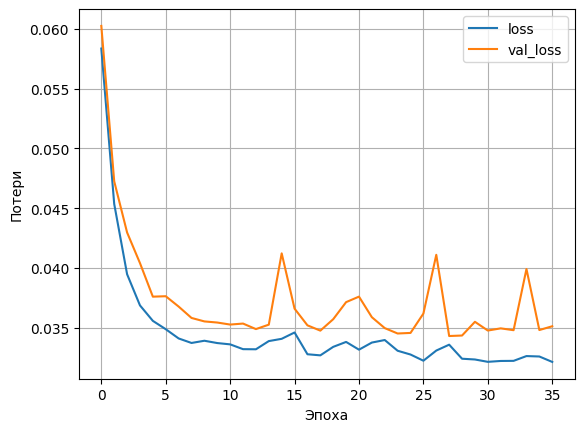

In [51]:

model_1.summary()

# функции потерь
plot_loss(history_1)


In [52]:
# Прогноз и оценка

y_pred_1 = model_1.predict(features_test)
get_metrics('Нейросеть model_1', y_test, y_pred_1)


10/10 [==============================] - 0s 2ms/step
MSE: 0.037330774191563984
R^2: -0.056735877891419095


### Модель 2

In [53]:
# Создаем  и обучаем модель

model_2 = keras.Sequential([
          layers.Dense(50, activation='tanh'),
          layers.Dense(12, activation='tanh'),
          layers.Dense(1, activation='relu'),
])

compile_model(model_2)

history_2 = model_2.fit(features_train,
                        y_train,
                        batch_size=32,
                        epochs=100,
                        validation_split=0.3,
                        callbacks=callbacks(2))  # номер модели

Epoch 1/100
16/16 [==============================] - 1s 30ms/step - loss: 0.0897 - mse: 0.0897 - val_loss: 0.0624 - val_mse: 0.0624
Epoch 2/100
16/16 [==============================] - 0s 21ms/step - loss: 0.0535 - mse: 0.0535 - val_loss: 0.0421 - val_mse: 0.0421
Epoch 3/100
16/16 [==============================] - 0s 16ms/step - loss: 0.0413 - mse: 0.0413 - val_loss: 0.0388 - val_mse: 0.0388
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0381 - mse: 0.0381 - val_loss: 0.0351 - val_mse: 0.0351
Epoch 5/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0357 - mse: 0.0357 - val_loss: 0.0343 - val_mse: 0.0343
Epoch 6/100
16/16 [==============================] - 0s 4ms/step - loss: 0.0343 - mse: 0.0343 - val_loss: 0.0352 - val_mse: 0.0352
Epoch 7/100
16/16 [==============================] - 0s 4ms/step - loss: 0.0348 - mse: 0.0348 - val_loss: 0.0374 - val_mse: 0.0374
Epoch 8/100
16/16 [==============================] - 0s 4ms/step - loss: 0.0368 

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 50)                650       
                                                                 
 dense_4 (Dense)             (None, 12)                612       
                                                                 
 dense_5 (Dense)             (None, 1)                 13        
                                                                 
Total params: 1,275
Trainable params: 1,275
Non-trainable params: 0
_________________________________________________________________


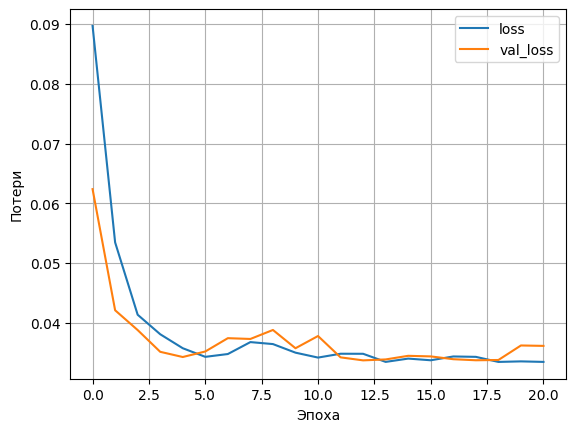

In [54]:

model_2.summary()
plot_loss(history_2)


In [55]:
# Прогноз и оценка

y_pred_2 = model_2.predict(features_test)
get_metrics('Нейросеть model_2', y_test, y_pred_2)


10/10 [==============================] - 0s 1ms/step
MSE: 0.039845083601377215
R^2: -0.1279093539044096


### Модель 3

In [56]:
# Создаем  и обучаем модель

model_3 = keras.Sequential([
          layers.Dense(24, activation='sigmoid'),
          layers.Dense(12, activation='sigmoid'),
          layers.Dense(1, activation='linear'),
])

compile_model(model_3)

history_3 = model_3.fit(features_train,
                        y_train,
                        batch_size=32,
                        epochs=100,
                        validation_split=0.3,
                        callbacks=callbacks(3))  # номер модели

Epoch 1/100
16/16 [==============================] - 1s 28ms/step - loss: 2.3600 - mse: 2.3600 - val_loss: 1.8094 - val_mse: 1.8094
Epoch 2/100
16/16 [==============================] - 0s 21ms/step - loss: 1.5386 - mse: 1.5386 - val_loss: 1.1346 - val_mse: 1.1346
Epoch 3/100
16/16 [==============================] - 0s 18ms/step - loss: 0.9575 - mse: 0.9575 - val_loss: 0.6804 - val_mse: 0.6804
Epoch 4/100
16/16 [==============================] - 0s 21ms/step - loss: 0.5733 - mse: 0.5733 - val_loss: 0.3939 - val_mse: 0.3939
Epoch 5/100
16/16 [==============================] - 0s 11ms/step - loss: 0.3337 - mse: 0.3337 - val_loss: 0.2222 - val_mse: 0.2222
Epoch 6/100
16/16 [==============================] - 0s 4ms/step - loss: 0.1917 - mse: 0.1917 - val_loss: 0.1251 - val_mse: 0.1251
Epoch 7/100
16/16 [==============================] - 0s 7ms/step - loss: 0.1121 - mse: 0.1121 - val_loss: 0.0742 - val_mse: 0.0742
Epoch 8/100
16/16 [==============================] - 0s 4ms/step - loss: 0.070

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 24)                312       
                                                                 
 dense_7 (Dense)             (None, 12)                300       
                                                                 
 dense_8 (Dense)             (None, 1)                 13        
                                                                 
Total params: 625
Trainable params: 625
Non-trainable params: 0
_________________________________________________________________


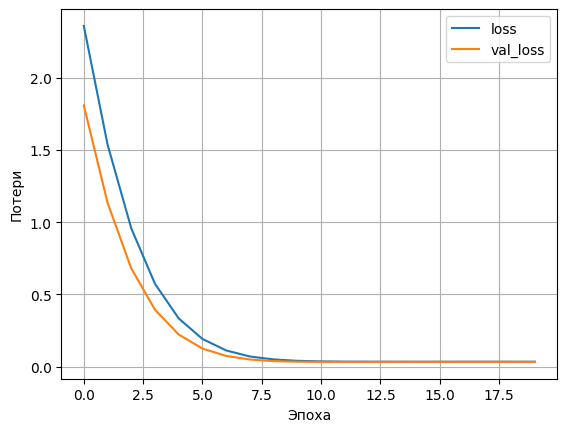

In [57]:
model_3.summary()
plot_loss(history_3)

In [58]:
# Прогноз и оценка

y_pred_3 = model_3.predict(features_test)
get_metrics('Нейросеть model_3', y_test, y_pred_3)

10/10 [==============================] - 0s 1ms/step
MSE: 0.03622544678353286
R^2: -0.025446970704833927


### Модель 4

In [59]:
# Создаем  и обучаем модель

model_4 = keras.Sequential([
          layers.Dense(24, activation='sigmoid'),
          layers.Dense(24, activation='sigmoid'),
          layers.Dense(1, activation='linear'),
])

compile_model(model_4)

history_4 = model_4.fit(features_train,
                        y_train,
                        batch_size=32,
                        epochs=100,
                        validation_split=0.3,
                        callbacks=callbacks(4))  # номер модели

Epoch 1/100
16/16 [==============================] - 1s 21ms/step - loss: 0.0360 - mse: 0.0360 - val_loss: 0.0324 - val_mse: 0.0324
Epoch 2/100
16/16 [==============================] - 0s 5ms/step - loss: 0.0345 - mse: 0.0345 - val_loss: 0.0336 - val_mse: 0.0336
Epoch 3/100
16/16 [==============================] - 0s 5ms/step - loss: 0.0342 - mse: 0.0342 - val_loss: 0.0352 - val_mse: 0.0352
Epoch 4/100
16/16 [==============================] - 0s 5ms/step - loss: 0.0345 - mse: 0.0345 - val_loss: 0.0342 - val_mse: 0.0342
Epoch 5/100
16/16 [==============================] - 0s 5ms/step - loss: 0.0339 - mse: 0.0339 - val_loss: 0.0328 - val_mse: 0.0328
Epoch 6/100
16/16 [==============================] - 0s 4ms/step - loss: 0.0340 - mse: 0.0340 - val_loss: 0.0327 - val_mse: 0.0327
Epoch 7/100
16/16 [==============================] - 0s 4ms/step - loss: 0.0339 - mse: 0.0339 - val_loss: 0.0337 - val_mse: 0.0337
Epoch 8/100
16/16 [==============================] - 0s 4ms/step - loss: 0.0342 - 

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 24)                312       
                                                                 
 dense_10 (Dense)            (None, 24)                600       
                                                                 
 dense_11 (Dense)            (None, 1)                 25        
                                                                 
Total params: 937
Trainable params: 937
Non-trainable params: 0
_________________________________________________________________


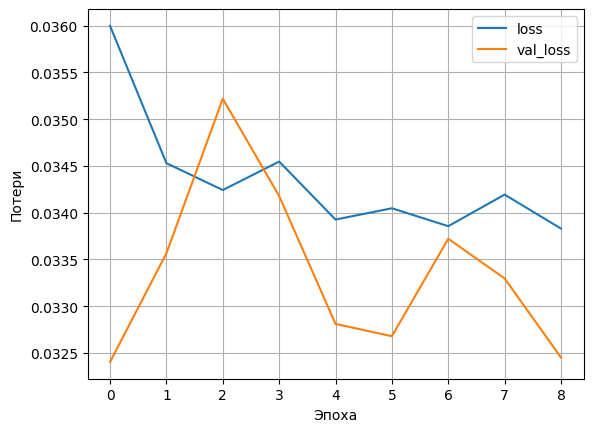

In [60]:
model_4.summary()
plot_loss(history_4)

In [61]:
# Прогноз и оценка

y_pred_4 = model_4.predict(features_test)
get_metrics('Нейросеть model_4', y_test, y_pred_4)

10/10 [==============================] - 0s 1ms/step
MSE: 0.035483839077667355
R^2: -0.004454010149359533


### Сравнение результатов тестирования

In [ ]:
# Визуализируем ошибки нейросетей

In [63]:
pred_list = [y_pred_1, y_pred_2, y_pred_3, y_pred_4]
y_test = np.array(y_test).reshape(307,1)

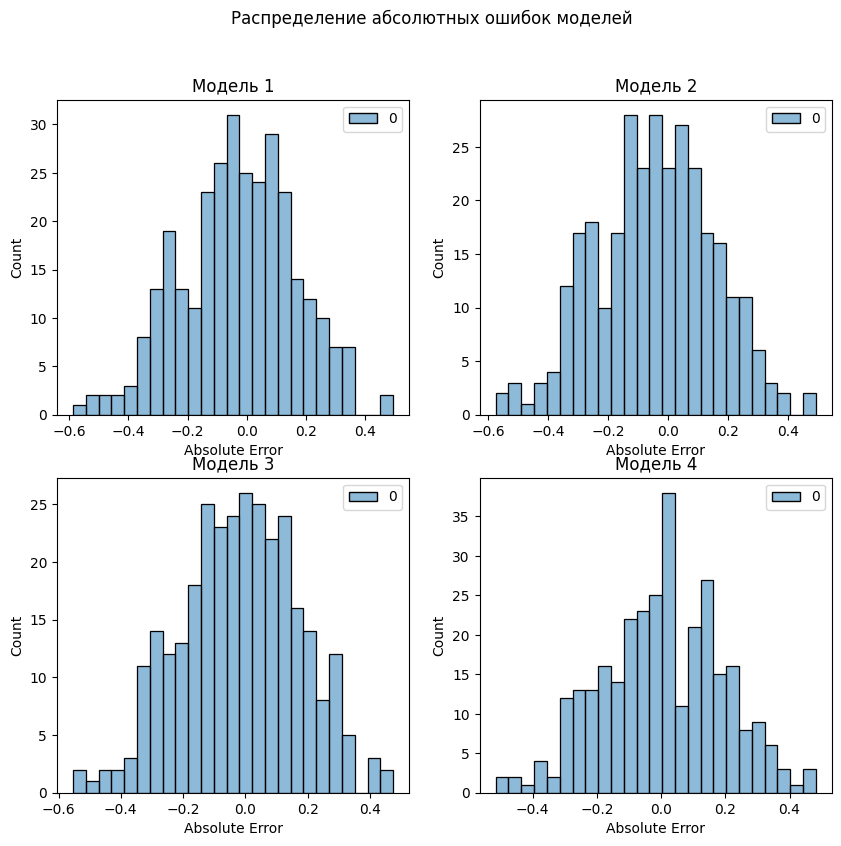

In [64]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 9))
fig.suptitle('Распределение абсолютных ошибок моделей')

for i, pred in enumerate(pred_list):
    error = y_test - pred
    row = i // 2
    col = i % 2
    sns.histplot(data=error, ax=axs[row, col], bins=25, kde=False)
    axs[row, col].set_xlabel('Absolute Error')
    axs[row, col].set_title(f'Модель {i+1}')
    
plt.show()

**<p style="text-align: center;">Ошибка и коэффицент детерминации нейросетей на тестовой выборке</p>**

In [65]:
result_neural.loc['Нейросеть model_4', 'Лучшие параметры'] = \
"Dense(24, 'sigmoid'), Dense(24, 'sigmoid'), Dense(1, 'linear')"

result_neural

,Прогнозируемая переменная,Лучшие параметры,Среднеквадратическая ошибка (MSE),Коэффициент детерминации (R^2)
Модель,,,,
Нейросеть model_1,Соотношение матрица-наполнитель,NaN,0.037,-0.057
Нейросеть model_2,Соотношение матрица-наполнитель,NaN,0.040,-0.128
Нейросеть model_3,Соотношение матрица-наполнитель,NaN,0.036,-0.025
Нейросеть model_4,Соотношение матрица-наполнитель,"Dense(24, 'sigmoid'), Dense(24, 'sigmoid'), De...",0.035,-0.004


Лучшая модель нейронной сети для прогнозирования Соотношения матрица-наполнитель - это Модель 4 следующей архитектуры:
- полносвязный Dense-слой, 24 нейрона, функция активации - sigmoid,  
- полносвязный Dense-слой, 24 нейрона, функция активации - sigmoid, 
- полносвязный Dense-слой, 1 нейрон, функция активации - linear

**<p style="text-align: center;">Метрики всех моделей на тестовой выборке</p>**

In [66]:
best_models_df = pd.concat([result_module, result_strength, result_neural], axis=0)
best_models_df

,Прогнозируемая переменная,Лучшие параметры,Среднеквадратическая ошибка (MSE),Коэффициент детерминации (R^2)
Модель,,,,
XGBRegressor,Модуль упругости при растяжении,"{'booster': 'gbtree', 'colsample_bytree': 1.0,...",0.037,-0.018
CatBoostRegressor,Модуль упругости при растяжении,"{'depth': 7, 'iterations': 10, 'l2_leaf_reg': ...",0.037,-0.022
RandomForestRegressor,Модуль упругости при растяжении,"{'max_depth': 2, 'min_samples_leaf': 4, 'min_s...",0.037,-0.022
Pipeline,Модуль упругости при растяжении,"{'polynomialfeatures__degree': 1, 'ridge__alph...",0.037,-0.008
XGBRegressor,Прочность при растяжении,"{'booster': 'gbtree', 'colsample_bytree': 1.0,...",0.036,-0.004
CatBoostRegressor,Прочность при растяжении,"{'depth': 7, 'iterations': 10, 'l2_leaf_reg': ...",0.036,0.007
RandomForestRegressor,Прочность при растяжении,"{'max_depth': 2, 'min_samples_leaf': 4, 'min_s...",0.036,0.005
Pipeline,Прочность при растяжении,"{'polynomialfeatures__degree': 1, 'ridge__alph...",0.036,-0.000
Нейросеть model_1,Соотношение матрица-наполнитель,NaN,0.037,-0.057


<font size=2>*Примечание*. Pipeline - комбинация полиномиальной интерполяции и Ridge-регрессии</font>